In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Data Preprocessing
Locate files:

C = Cuivre / Copper / Cu
Z = Zinc / Zn
M = Methomyl

In [2]:
#Apply tail filter to final half hour of data
def sigmoid(x):
    """
    Sigmoid function.
    """
    return 1 / (1 + np.exp(-x))

def smooth_tail_to_zero(arr, window_size=30*3):
    """
    Apply sigmoid filtering to the last 'window_size' values of a time series.

    Parameters:
    - time_series: Numpy array.
    - window_size: Number of values to apply the sigmoid filtering (default: 30).

    Returns:
    - Filtered time series.
    """
    # Copy arr to arr_filtered
    arr_filtered = arr.copy()

    # Extract the last 'window_size' values
    tail_values = arr[-window_size:]

    # Generate a reversed sigmoid function with the same length as the tail
    sigmoid_values = sigmoid(np.linspace(6, -6, window_size))

    # Apply reversed sigmoid filtering to the tail
    smoothed_tail = tail_values * sigmoid_values

    # Replace the tail in the original time series with the smoothed values
    arr_filtered[-window_size:] = smoothed_tail

    return arr_filtered


In [3]:
def extract_substances(dataframe):
    # Get the column names from the DataFrame
    columns = dataframe.columns

    # Create a dictionary to store the count of each unique substance
    substance_counts = {}

    # Extract unique substances from the column names and count occurrences
    for column in columns:
        # Split the column name based on the numeric part
        substance = ''.join([i for i in column if not i.isdigit()])
        
        # Update the count in the dictionary
        substance_counts[substance] = substance_counts.get(substance, 0) + 1

    # Convert the dictionary to two lists (substances and counts) and sort them
    unique_substances_list = sorted(list(substance_counts.keys()))
    counts_list = [substance_counts[substance] for substance in unique_substances_list]

    return unique_substances_list,counts_list

In [4]:
def get_fp_data(fpc_object,pcs = 2,gridpoints = np.arange(360)):
    """
    'Inputs'
    fpc_obj - functional data object already in pca form (1-D)
    pcs - number of functional principal components to take into account (int)
    
    'Outputs'
    np.arr - X array (gridpoints)
    np.arr 2D - Y arrays (data points - no. fpcs - 2 by default)
    """
    fpc_grid_points = fpc_object.components_.to_grid(gridpoints).grid_points[0]
    fpc_data_points = [np.zeros_like(fpc_grid_points) for i in range(pcs)]
    fpc_variance_exp = np.array([fpc_object.explained_variance_ratio_[i] for i in range(pcs)])
    for i in range(pcs):
        fpc_data_points[i] = fpc_object.components_.to_grid(gridpoints)[i].data_matrix[0].flatten()
        
    return fpc_grid_points,fpc_data_points,fpc_variance_exp
    

### FPCA for individual species

In [5]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [6]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
mean = True #if IGT should be false
data = {s:pd.read_csv(r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s])) for s in specie}

In [7]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.013496,0.010313,0.006673,0.004786,0.185005,0.0,0.045759,0.0,0.0,...,0.0,0.027120,0.0,0.005985,0.0,0.017634,0.0,0.024239,0.027087,0.000000
1,0.004483,0.016588,0.010062,0.005755,0.004799,0.181456,0.0,0.038471,0.0,0.0,...,0.0,0.025385,0.0,0.005561,0.0,0.017054,0.0,0.028436,0.035160,0.000000
2,0.000000,0.014006,0.009641,0.005196,0.004684,0.180394,0.0,0.031634,0.0,0.0,...,0.0,0.024105,0.0,0.005051,0.0,0.015857,0.0,0.034271,0.039412,0.004712
3,0.000000,0.011910,0.009293,0.005245,0.004482,0.178462,0.0,0.027380,0.0,0.0,...,0.0,0.022787,0.0,0.004525,0.0,0.013629,0.0,0.039724,0.038390,0.005609
4,0.000000,0.010553,0.009516,0.005864,0.007022,0.178143,0.0,0.024033,0.0,0.0,...,0.0,0.021368,0.0,0.005905,0.0,0.013543,0.0,0.032204,0.038384,0.005814


In [8]:
#identify all used substances
substances,counts = extract_substances(data[[*data][0]])
substances,counts

(['Copper', 'Methomyl', 'Verapamil', 'Zinc'], [8, 7, 3, 4])

In [9]:
plot_colors = {'Copper':'#8c564b','Methomyl':'#9467bd','Verapamil':'#d62728','Zinc':'#e377c2'}
custom_palette = [plot_colors[s] for s in plot_colors]
sns.set_palette(custom_palette)
custom_palette

['#8c564b', '#9467bd', '#d62728', '#e377c2']

In [10]:
#Define columns and y values for functional data analysis
cols = data[[*data][0]].columns
y = ['{}'.format(s) for i,s in enumerate(substances) for x in range(counts[i])]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Verapamil',
 'Verapamil',
 'Verapamil',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

### Plot each data curve for each species

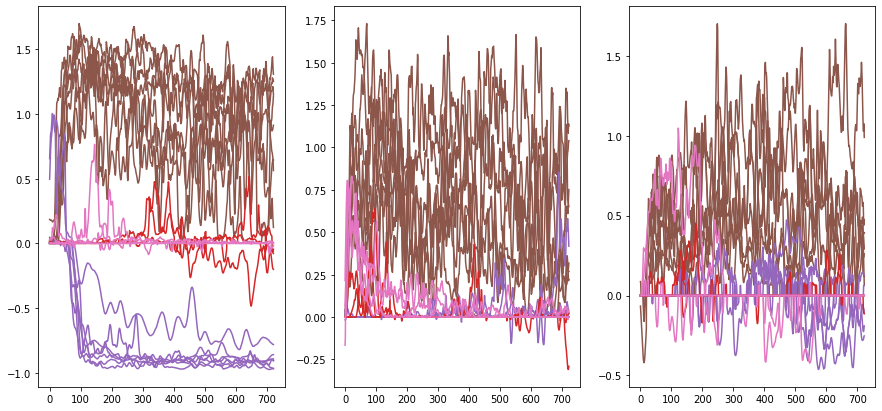

In [11]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    for x,col in enumerate(data[s].columns):
        axes[i].plot(data[s].index,data[s][col].values,color = plot_colors[y[x]])

### Import relevant Data Structures and convert to FD Data Grids and BSplines

In [12]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [13]:
#Define timestep for data and remove end data
timestep = 30
full_length = data[[*data][0]].shape[0]
#n_rows = (full_length//timestep)*timestep
n_rows = 360

In [14]:
#Cut dataframe at n_rows
for s in specie:
    data[s] = data[s].iloc[:n_rows]
    
data[s].shape

(360, 22)

In [15]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.013496,0.010313,0.006673,0.004786,0.185005,0.0,0.045759,0.0,0.0,...,0.0,0.027120,0.0,0.005985,0.0,0.017634,0.0,0.024239,0.027087,0.000000
1,0.004483,0.016588,0.010062,0.005755,0.004799,0.181456,0.0,0.038471,0.0,0.0,...,0.0,0.025385,0.0,0.005561,0.0,0.017054,0.0,0.028436,0.035160,0.000000
2,0.000000,0.014006,0.009641,0.005196,0.004684,0.180394,0.0,0.031634,0.0,0.0,...,0.0,0.024105,0.0,0.005051,0.0,0.015857,0.0,0.034271,0.039412,0.004712
3,0.000000,0.011910,0.009293,0.005245,0.004482,0.178462,0.0,0.027380,0.0,0.0,...,0.0,0.022787,0.0,0.004525,0.0,0.013629,0.0,0.039724,0.038390,0.005609
4,0.000000,0.010553,0.009516,0.005864,0.007022,0.178143,0.0,0.024033,0.0,0.0,...,0.0,0.021368,0.0,0.005905,0.0,0.013543,0.0,0.032204,0.038384,0.005814


In [16]:
#define FDA parameters with uneven knots
domain_range = (0,n_rows)
order = 4

#define knots with uneven spacing
knots = np.hstack((np.array([0,30,60,90,120,150]),np.arange(180,n_rows+90,90)))
#knots = np.hstack((np.array([0,30,60,90,120,150]),np.arange(180,181)))

n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
knots

array([  0,  30,  60,  90, 120, 150, 180, 270, 360])

In [17]:
#define grid points and data matrices
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

#define functional data grids
fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

### Create basis functions

In [18]:
#create basis functions
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [19]:
X_bss = {s:fds[s].to_basis(bss) for s in specie}

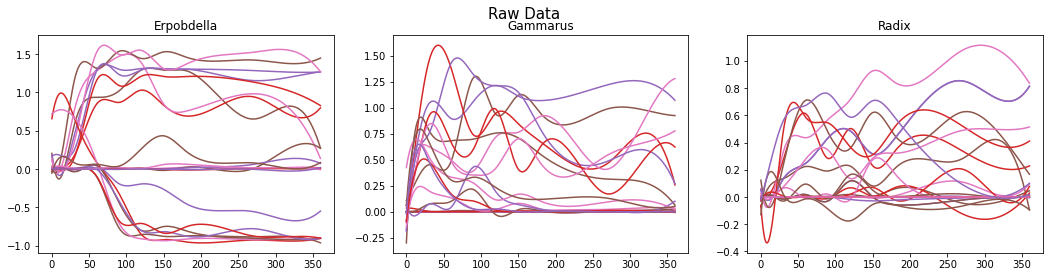

In [20]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

In [21]:
test = X_bss['E'].to_grid(grid_points = np.arange(360))

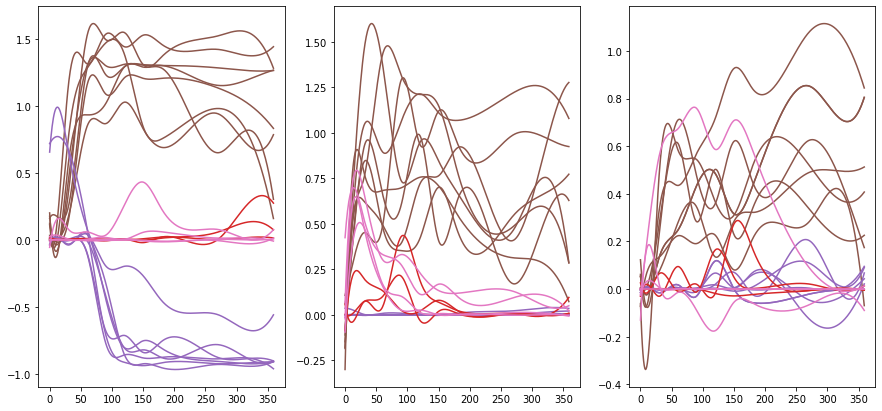

In [22]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    X_grid = X_bss[s].to_grid(grid_points = np.arange(n_rows))
    for x,col in enumerate(data[s].columns):
        axes[i].plot(X_grid.grid_points[0],X_grid.data_matrix[x].flatten(),color = plot_colors[y[x]])

## FPCA

In [23]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [24]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

In [25]:
fpcas['E'].components_

FDataBasis(
    basis=BSplineBasis(domain_range=((0.0, 360.0),), n_basis=11, order=4, knots=(0, 30, 60, 90, 120, 150, 180, 270, 360)),
    coefficients=[[-0.0021012  -0.01525925  0.01233773  0.04016187  0.05349456  0.06320588
       0.05751794  0.05955531  0.05742152  0.05927163  0.05292824]
     [ 0.066071    0.04894715  0.16189631  0.08995616  0.0663765   0.00686555
      -0.01910323 -0.01913438 -0.0014105  -0.02888095 -0.05525187]],
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None)

Text(0.5, 1.0, 'Functional Principal Component plot')

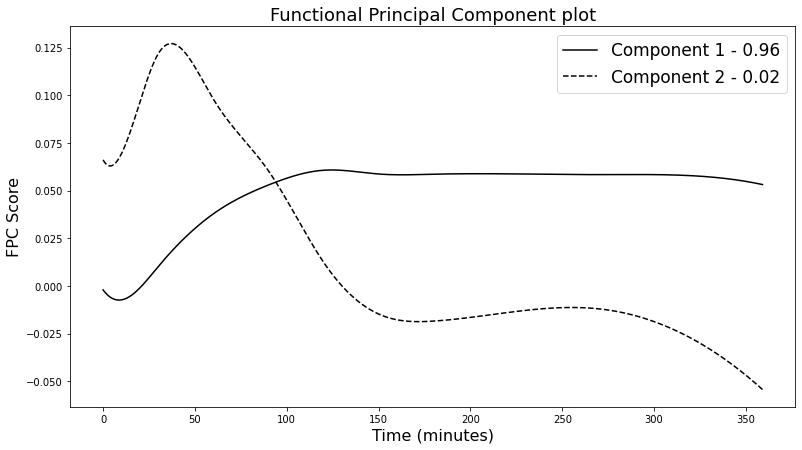

In [26]:
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['E'],gridpoints = np.arange(n_rows))

#plot each component
fig,ax = plt.subplots(figsize = (13,7))
ax.plot(grid_points,data_points[0],color = 'black')
ax.plot(grid_points,data_points[1],color = 'black',linestyle = '--')
ax.legend(labels=['Component 1 - {:.2f}'.format(variances[0]),
                  'Component 2 - {:.2f}'.format(variances[1])],
         fontsize = 17)
ax.set_xlabel('Time (minutes)',fontsize = 16)
ax.set_ylabel('FPC Score',fontsize = 16)
ax.set_title('Functional Principal Component plot',fontsize = 18)

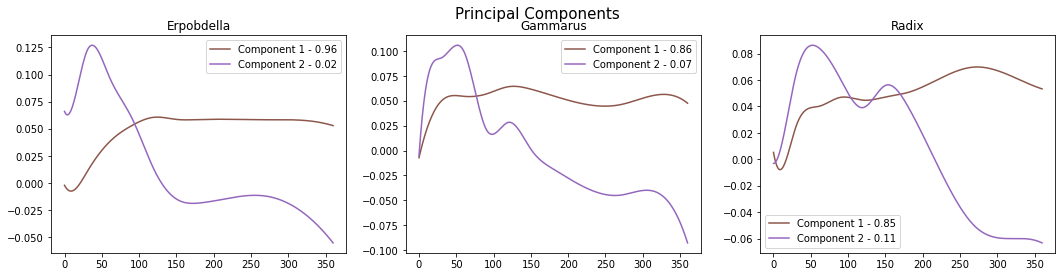

In [27]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Principal Components',fontsize = 15)
for i,s in enumerate(specie):
    fpcas[s].components_.plot(axes = axe[i])
    axe[i].legend(
        labels=['Component 1 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[0]),
                'Component 2 - {:.2f}'.format(fpcas[s].explained_variance_ratio_[1])])
    axe[i].set_title(specie[s])

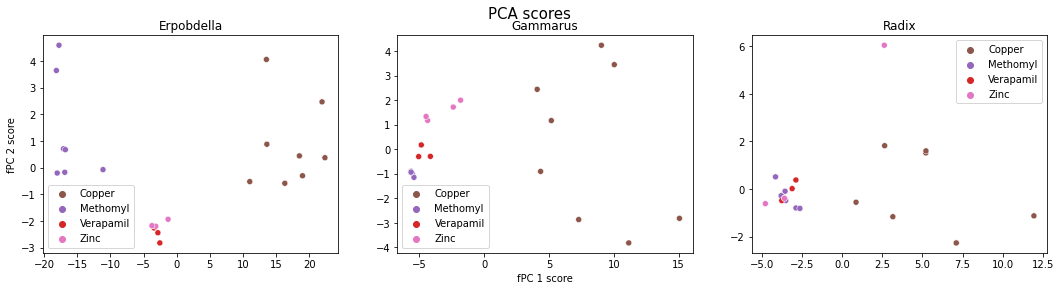

In [28]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

In [29]:
scores['E']

array([[ 13.61459489,   0.88066481],
       [ 18.52329715,   0.44411884],
       [ 11.03465466,  -0.52155605],
       [ 13.54269274,   4.0622281 ],
       [ 21.93851163,   2.47131849],
       [ 18.99169193,  -0.30246188],
       [ 16.32352709,  -0.58407322],
       [ 22.37581451,   0.3751843 ],
       [-18.0277726 ,  -0.19997844],
       [-11.11034517,  -0.07190179],
       [-17.75689128,   4.59555081],
       [-18.14885247,   3.64725999],
       [-17.07077678,   0.71002251],
       [-16.7939157 ,   0.67712277],
       [-16.87969746,  -0.17152061],
       [ -3.40506868,  -2.26071898],
       [ -2.53829706,  -2.82226203],
       [ -2.83096582,  -2.43998395],
       [ -3.60606305,  -2.18109794],
       [ -3.15462954,  -2.19752367],
       [ -1.29355097,  -1.93448017],
       [ -3.72795801,  -2.17591189]])

## MultiVector FDA

Whilst this is possible to create multidimensional Vector grids, their combination has not yet been achieved.

In [30]:
from skfda.representation.basis import VectorValuedBasis

In [31]:
n_rows

360

In [32]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)

In [33]:
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

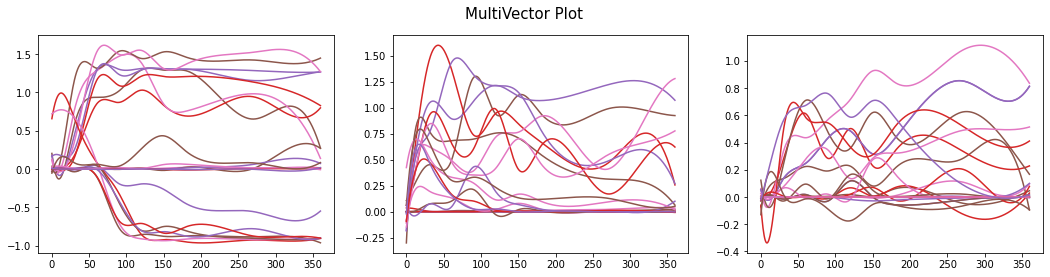

In [34]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

### What appears strange here is there is not exactly the same PCA for each domain 

Perhaps there is some kind of normalisation

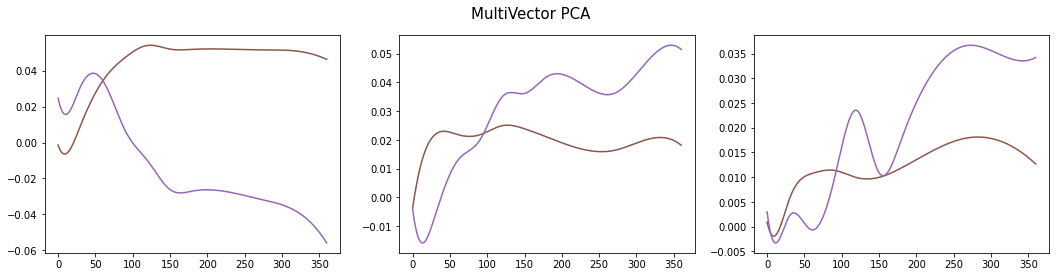

In [35]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [36]:
### Failed PCA plot attempt
scores = vector_fpca.fit_transform(vector_bss)
scores

array([[ 16.52869137,   3.62065995],
       [ 23.97078478,   6.48207757],
       [ 14.00037552,   0.77266656],
       [ 17.81504156,   7.45091587],
       [ 22.4261117 ,  -3.96033501],
       [ 22.5575552 ,   1.19788108],
       [ 17.82894971,  -1.44427934],
       [ 22.36274744,  -4.0540375 ],
       [-19.05467799,   2.33773454],
       [-12.99986445,  -0.25750901],
       [-18.97957084,   3.41056771],
       [-18.91793786,   4.08418683],
       [-18.28742905,   2.30957658],
       [-17.9757207 ,   2.24281563],
       [-17.83001624,   2.38060423],
       [ -5.62714962,  -3.95689286],
       [ -5.00585314,  -4.63637012],
       [ -5.06966971,  -4.02144221],
       [ -5.75256404,  -4.12048961],
       [ -4.58315272,  -3.30638853],
       [ -2.99071603,  -4.17546112],
       [ -4.41593489,  -2.35648123]])

In [37]:
scores_fp1 = scores[:,0]
scores_fp2 = scores[:,1]
scores_fp1

array([ 16.52869137,  23.97078478,  14.00037552,  17.81504156,
        22.4261117 ,  22.5575552 ,  17.82894971,  22.36274744,
       -19.05467799, -12.99986445, -18.97957084, -18.91793786,
       -18.28742905, -17.9757207 , -17.83001624,  -5.62714962,
        -5.00585314,  -5.06966971,  -5.75256404,  -4.58315272,
        -2.99071603,  -4.41593489])

In [38]:
positive_scores = scores[scores>0]
negative_scores = -scores[scores<0]

log_positive_scores = np.log(1+positive_scores)
log_negative_scores = np.log(1+negative_scores)

log_scores = np.empty_like(scores)
log_scores[scores>0] = log_positive_scores
log_scores[scores<0] = -log_negative_scores

log_scores

array([[ 2.86383905,  1.53053754],
       [ 3.21770653,  2.0125105 ],
       [ 2.70807524,  0.57248494],
       [ 2.93465663,  2.13427482],
       [ 3.15385129, -1.60147328],
       [ 3.15944658,  0.78749375],
       [ 2.93539556, -0.89375033],
       [ 3.15114276, -1.62018743],
       [-2.99846244,  1.2052923 ],
       [-2.63904765, -0.22913279],
       [-2.99471029,  1.48400341],
       [-2.99162073,  1.6261351 ],
       [-2.95945354,  1.19682026],
       [-2.9431603 ,  1.17644197],
       [-2.93545221,  1.21805446],
       [-1.89117479, -1.60077911],
       [-1.79273452, -1.72924026],
       [-1.80330419, -1.61371719],
       [-1.90992229, -1.63325006],
       [-1.71975362, -1.46009963],
       [-1.38397067, -1.64392844],
       [-1.68934551, -1.21089317]])

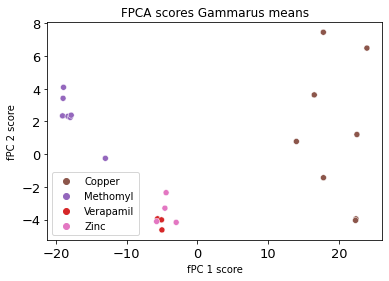

In [39]:
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Gammarus means")

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()

# Clustering

**Clustering methods should be fed the smoothed data not the basis data - it must be loaded in**

In [310]:
from skfda.exploratory.visualization.clustering import (
    ClusterMembershipLinesPlot,
    ClusterMembershipPlot,
    ClusterPlot
)
from skfda.ml.clustering import FuzzyCMeans,KMeans

## Single basis clusters

In [311]:
#Clustering unsupervised (except no. clusters)
n_clusters = 4
seed = 0

kmeans = {s:KMeans(n_clusters = n_clusters, random_state = seed).fit(X_bss[s].to_grid()) for s in specie}
for s in specie:
    print('Kmeans prediction: {}'.format(specie[s]))
    print(kmeans[s].predict(X_bss[s].to_grid()))

Kmeans prediction: Erpobdella
[0 0 0 0 0 0 0 0 2 2 1 1 2 1 2 3 3 3 3 3 3 3]
Kmeans prediction: Gammarus
[1 1 1 1 1 1 1 1 0 2 0 0 0 3 2 1 0 1 0 0 0 0]
Kmeans prediction: Radix
[0 1 2 1 2 1 1 1 3 3 0 3 3 3 3 0 3 3 3 3 0 2]


In [312]:
vector_kmean = KMeans(n_clusters = 4, random_state = seed).fit(vector_bss.to_grid())
vector_kmean.predict(vector_bss.to_grid())

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 2, 1, 3, 1, 3, 3, 3, 3])